In this simple kernel, I'm going to guess the degree a patient has Pneumothorax, and fill the submission with the most frequent masked pixels.

I know it is somewhat silly, but let's play around with the dataset.

Thanks to [@seesee](https://www.kaggle.com/seesee), the dataset is now available on Kaggle as well:
https://www.kaggle.com/seesee/siim-train-test

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pylab as pl
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dcm 
from glob import glob


Width, Height = 1024, 1024

# modified from the provided .py files
def mask2rle(img, width=Width, height=Height):
    if img is None or pl.isnan(img).all():
        return '-1'
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width=Width, height=Height):
    mask= np.zeros(width* height)
    if rle == '-1' or rle == ' -1':
        return mask.reshape(width, height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)



In [2]:
trFolders = glob(r'siim/dicom-images-train/*')
tsFolders = glob(r'siim/dicom-images-test/*')
trainDF = pd.read_csv(r'siim/train-rle.csv', index_col='ImageId')

DCM files have many attributes, that in our case only **ViewPosition**, **PatientAge**, **PatientSex** had meaningful values. View Position has two values of PA and AP, which are most probably posterior-anteror and anterior-posterior. They show the direction at which the scan was taken. i.e. from front or from back. (Correct me if I'm wrong)

In [3]:
Attrs = ['ViewPosition', 'PatientAge', 'PatientSex',
#         'StudyDate', 'Modality', 'ConversionType',
#          'ReferringPhysicianName','BodyPartExamined',
#          'SeriesNumber', 'InstanceNumber','PatientOrientation',
#          'SamplesPerPixel','PhotometricInterpretation','Rows', 'Columns', 
#         'PixelSpacing','BitsAllocated','BitsStored','HighBit', 'PixelRepresentation', 
#         'LossyImageCompression', 'LossyImageCompressionMethod',
        ]


def readMetaData(Folders, DF=pd.DataFrame()):
    missing = []
    for Fol in Folders:
        Sub = glob(Fol+'/*')
        File = glob(Sub[0]+'/*.dcm')[0]
        ID = File.split('/')[-1][:-4]
        try:
            DCM = dcm.dcmread(File)
            for atr in Attrs:
                DF.loc[ID, atr] = getattr(DCM, atr)
            Im = DCM.pixel_array
            for i, Part in enumerate([Im, 
                            Im[:512, :512], 
                            Im[:512, 512:], 
                            Im[512:, :512], 
                            Im[512:, 512:]]):
                DF.loc[ID, 'ImageMean_%d'%i] = Part.mean()
                DF.loc[ID, 'ImageStd_%d'%i] = Part.std()
        except Exception:
            missing.append(File)
    return DF, missing

In [5]:
trainDF, missingTR = readMetaData(trFolders, trainDF)
testDF, missingTS = readMetaData(tsFolders)
#print(f'{len(missingTR)} files in train set are not downloaded perperly')
#print(f'{len(missingTS)} files in test set are not downloaded perperly')

IndexError: list index out of range

From the provided masks I creat a new target column which shows the greatness (size) of the *Pneumothorax* and its log values. Later I'm going to predict this value based on only simple features provided in the metadata of the files.

In [5]:
trainDF.rename(columns={' EncodedPixels':'EncodedPixels'}, inplace=True)
trainDF['PneumMask'] = trainDF.EncodedPixels.apply(rle2mask)
trainDF['PneumSize'] = trainDF.PneumMask.apply(lambda mask: len(np.where(mask>0)[0]))
trainDF['PneumSizeLog'] = trainDF.PneumSize.apply(np.log1p)
trainDF.dropna(inplace=True)

The masks are located on the lungs and if we aggregate them on top of each other:

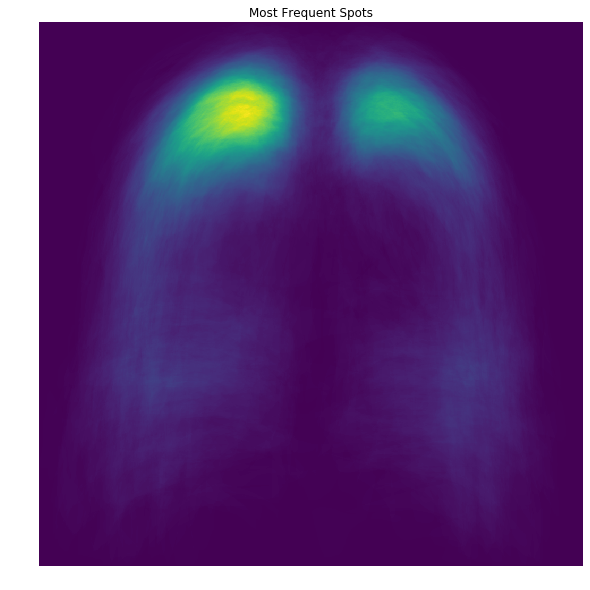

In [6]:
MaskFreq = np.mean(trainDF[trainDF.PneumSize > 0].PneumMask.values, 0)
MaskFreq /= 255  # when the pixel is present in the mask, its value is 255
# It is the probability of being in the mask if the patient is diagnosed with Pneumothorax.

pl.figure(figsize=(10,10))
pl.imshow(MaskFreq.T);
pl.title('Most Frequent Spots')
pl.axis('off');

We can see there are locations in the lungs more vulnerable to Pneumothorax. We later use this Map to guess Pneumothorax spots in the test set.

Let's take a look at frequency of Pneumothorax spots for different meta-data conditions:

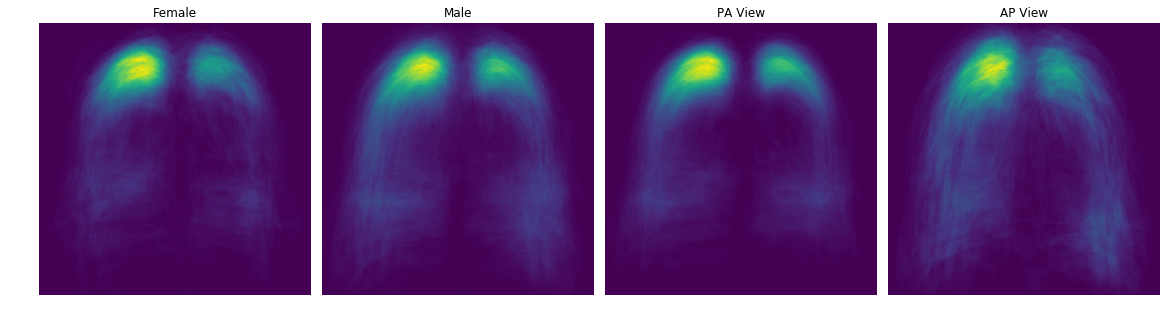

In [7]:
pl.figure(figsize=(16,5))
for i, (Cond, Label)  in enumerate(zip([trainDF.PatientSex=='F', 
                                     trainDF.PatientSex=='M', 
                                     trainDF.ViewPosition=='PA', 
                                     trainDF.ViewPosition=='AP'], 
                                    ['Female','Male','PA View', 'AP View'])):
    pl.subplot(1,4,i+1)
    pl.imshow(np.sum(trainDF[Cond].PneumMask.values, 0).T);
    pl.title(Label)
    pl.axis('off');
pl.subplots_adjust(wspace=0.01, left=0.01, right=0.99)

Lets continue with preparing datasets:

Some data cleaning is always necessary, here we should decide what to do with ages greater than 100. I guess they are typos, so I divide them by 10.

In [8]:
for DF in [trainDF, testDF]:
    DF['PatientAge'] = DF.PatientAge.astype(int)
    DF['PatientAge'] = DF.PatientAge.apply(lambda x:x if x<100 else int(x/10))


In [9]:
trainDF.head()

,EncodedPixels,ViewPosition,PatientAge,PatientSex,ImageMean_0,ImageStd_0,ImageMean_1,ImageStd_1,ImageMean_2,ImageStd_2,ImageMean_3,ImageStd_3,ImageMean_4,ImageStd_4,PneumMask,PneumSize,PneumSizeLog
ImageId,,,,,,,,,,,,,,,,,
1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1,PA,51,F,111.051293,27.263829,96.550907,17.643129,83.256142,22.363796,134.030598,9.381933,130.367527,13.777827,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0.000000
1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1,AP,17,F,90.784574,67.698396,85.585236,45.883689,79.771843,53.825562,98.030373,78.351568,99.750843,83.124064,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0.000000
1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002...,PA,69,F,120.755042,63.521915,115.058567,55.475317,83.411964,53.584097,154.442581,58.273063,130.107056,64.392181,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9418,9.150484
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...,AP,57,F,114.152170,54.190251,108.360252,34.826555,95.933071,37.200734,141.814026,64.817927,110.501331,61.678174,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1856,7.526718
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...,AP,57,F,114.152170,54.190251,108.360252,34.826555,95.933071,37.200734,141.814026,64.817927,110.501331,61.678174,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",7684,8.947026


In [10]:
testDF.head()

,ViewPosition,PatientAge,PatientSex,ImageMean_0,ImageStd_0,ImageMean_1,ImageStd_1,ImageMean_2,ImageStd_2,ImageMean_3,ImageStd_3,ImageMean_4,ImageStd_4
1.2.276.0.7230010.3.1.4.8323329.6536.1517875198.802172,PA,21,F,143.205869,61.626643,110.259136,54.263939,115.911991,52.324003,161.838230,63.902496,184.814117,38.943715
1.2.276.0.7230010.3.1.4.8323329.6894.1517875201.804774,PA,65,F,134.911562,60.638505,105.838779,50.832580,101.666340,46.534039,173.894569,54.286345,158.246559,54.745498
1.2.276.0.7230010.3.1.4.8323329.5827.1517875191.350766,AP,45,M,109.344993,60.762430,67.787945,44.599873,79.120235,51.200692,128.039364,61.079645,162.432426,24.872268
1.2.276.0.7230010.3.1.4.8323329.6510.1517875198.659480,AP,34,M,147.757547,51.697596,149.899071,30.954201,141.986679,38.502638,157.825439,63.542140,141.319000,63.495198
1.2.276.0.7230010.3.1.4.8323329.6947.1517875202.67033,PA,50,F,155.663195,65.998847,110.394516,57.694622,116.096127,54.879513,200.830681,42.451650,195.331455,45.302752


Distribution of Patient Ages seems to be similar in train and test sets:

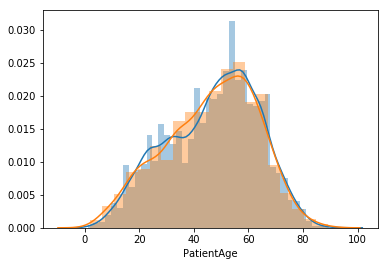

In [11]:
sns.distplot(trainDF.PatientAge);
sns.distplot(testDF.PatientAge);

In [12]:
print('Train Set:\n', trainDF.PatientSex.value_counts())
print('Test Set:\n', testDF.PatientSex.value_counts())

Train Set:
 M    6421
F    5161
Name: PatientSex, dtype: int64
Test Set:
 M    747
F    630
Name: PatientSex, dtype: int64


In [13]:
print('Train Set:\n', trainDF.ViewPosition.value_counts())
print('Test Set:\n', testDF.ViewPosition.value_counts())

Train Set:
 PA    7104
AP    4478
Name: ViewPosition, dtype: int64
Test Set:
 PA    783
AP    594
Name: ViewPosition, dtype: int64


There are more Male subjects, and more PA scans in both of the train and test sets.

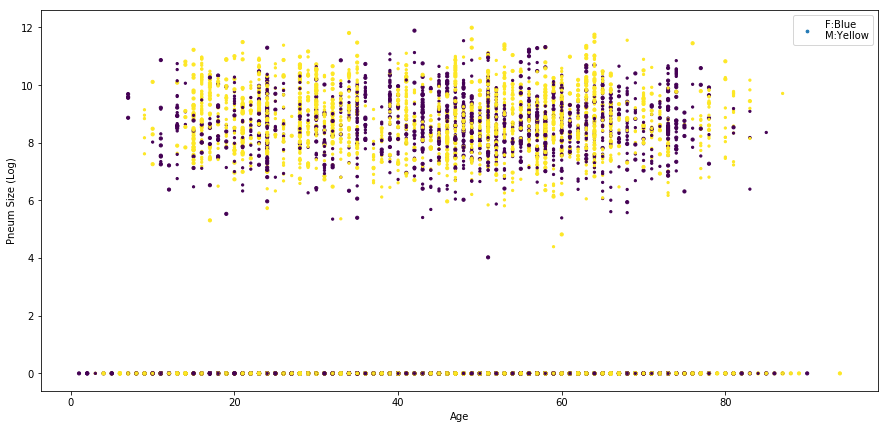

In [14]:
pl.figure(figsize=(15,7))
pl.scatter(trainDF.PatientAge, trainDF.PneumSizeLog, 
           c=list(map(lambda k: 5 if k == 'F' else  10, trainDF.PatientSex)),
           s=list(map(lambda k: 5 if k == 'PA' else 10, trainDF.ViewPosition)), 
          )
pl.xlabel('Age')
pl.ylabel('Pneum Size (Log)')
pl.legend(['F:Blue \nM:Yellow']);

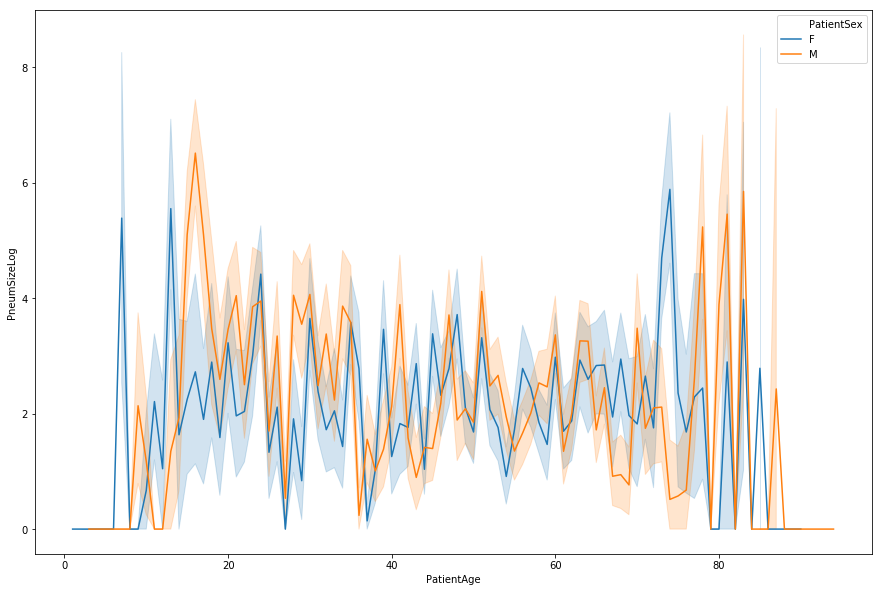

In [15]:
pl.figure(figsize=(15,10))
sns.lineplot(x='PatientAge',hue='PatientSex', y='PneumSizeLog', data=trainDF);

The relation of detected Pneum Size to the Patients age, sex, and imaging direction is not strong.

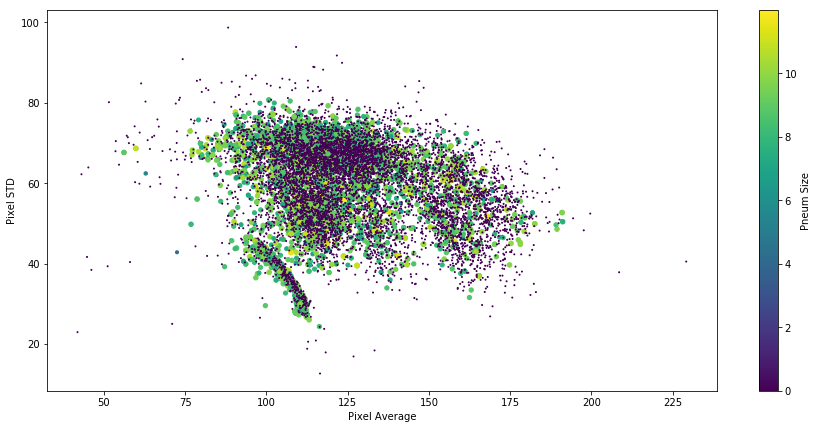

In [16]:
pl.figure(figsize=(15,7))
pl.scatter(trainDF.ImageMean_0, trainDF.ImageStd_0, c=trainDF.PneumSizeLog, s=trainDF.PneumSizeLog*2+1);
pl.xlabel('Pixel Average')
pl.ylabel('Pixel STD')
cb=pl.colorbar()
cb.set_label('Pneum Size')

Simple Pixel statistics also don't seem to be predictive of Pneum Size. 

But Let's build our model anyways:

I make a simple CatBoostRegressor model with no fancy hyper-parameters:

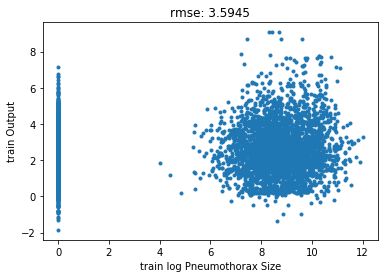

In [17]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse

Vars = ['ViewPosition', 'PatientAge', 'PatientSex'] + \
        sum([['ImageMean_%d'%i, 'ImageStd_%d'%i] for i in range(5)], []) 
nFolds = 10
trOutput = pl.zeros(len(trainDF))
tsOutput = pl.zeros(len(testDF))
spliter = KFold(nFolds)
for trInx, vlInx in spliter.split(trainDF[Vars], trainDF.PneumSizeLog):
    Xtr, Xvl = trainDF[Vars].iloc[trInx], trainDF[Vars].iloc[vlInx]
    Ytr, Yvl = trainDF.PneumSizeLog.iloc[trInx], trainDF.PneumSizeLog.iloc[vlInx]
    Reg = CatBoostRegressor(objective='RMSE', n_estimators=10000)
    Reg.fit(Xtr, Ytr, cat_features=['ViewPosition', 'PatientSex'], silent=True,
            eval_set=[(Xvl, Yvl)], early_stopping_rounds=500)
    trOutput[vlInx] = Reg.predict(Xvl)
    tsOutput += Reg.predict(testDF[Vars]) / nFolds

pl.plot(trainDF.PneumSizeLog, trOutput, '.')
pl.title('rmse: %.5g' % mse(trainDF.PneumSizeLog, trOutput)**0.5)
pl.xlabel('train log Pneumothorax Size')
pl.ylabel('train Output');

In [18]:
tsOutput[tsOutput<0] = 0
testDF['PneumSize'] = np.expm1(tsOutput)

Based on the Frequency of Pneumothorax spots and predicted size of the colapsed area we can extract masks that are most probable, with the desired size:

In [19]:
def getMask(numPos, MaskFreq=MaskFreq):
    prob = MaskFreq / MaskFreq.sum() * numPos
    return np.where(pl.rand(prob.shape[0], prob.shape[1])<=prob, 255, 0)


testDF['Mask'] = testDF.PneumSize.apply(getMask)

Let's make a submission based on that:

In [20]:
sub = pd.read_csv('../input/siim-acr-pneumothorax-segmentation/sample_submission.csv', index_col='ImageId')
sub = sub.join(testDF[['Mask']])
sub['EncodedPixels'] = sub.Mask.apply(mask2rle)
sub[['EncodedPixels']].to_csv('submission.csv', index_label='ImageId')

In [21]:
sub.sample(10)

,EncodedPixels,Mask
1.2.276.0.7230010.3.1.4.8323329.5954.1517875193.59697,226204 1 93392 1 497769 1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1.2.276.0.7230010.3.1.4.8323329.6937.1517875202.19296,418954 1 246856 1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1.2.276.0.7230010.3.1.4.8323329.695.1517875164.106587,210743 1 146117 1 450223 1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1.2.276.0.7230010.3.1.4.8323329.5967.1517875193.158996,601901 1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1.2.276.0.7230010.3.1.4.8323329.5823.1517875191.296784,450674 1 327041 1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1.2.276.0.7230010.3.1.4.8323329.668.1517875163.968012,90881 1 519582 1 5256 1 118651 1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1.2.276.0.7230010.3.1.4.8323329.6520.1517875198.721077,411839 1 154747 1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1.2.276.0.7230010.3.1.4.8323329.6473.1517875198.462294,374968 1 16311 1 88023 1 298095 1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1.2.276.0.7230010.3.1.4.8323329.6752.1517875199.981513,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1.2.276.0.7230010.3.1.4.8323329.6857.1517875201.561042,401827 1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
